# ANALYSIS OF FINANCIAL STATEMENTS AND JOURNAL ENTRIES [Demo]
The analysis is based on the following data:
- Journal Entries (5 years)
- Financial Statements (5 years)
- Financial Statements of the 5 Most Significant Competitors (1 year)

The goal of this analysis is to test and visualize the results, prepare data for a Power BI report, and present a financial analysis based on three sources of information, while identifying areas for further in-depth exploration.

This example represents a concise analysis of a company's financial data, designed as a demonstration of data analysis capabilities using journal entries and financial statements.

In [ ]:
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

In [ ]:
# Helper variables
years = [2019, 2020, 2021, 2022, 2023]
current_year = max(years)

## Scripts
# financial components extraction
exec(requests.get("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/src/components.py").text)

# visualization
exec(requests.get("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/src/visualization_eng.py").text)

# # utilities
exec(requests.get("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/src/utilities.py").text)

Controller for Saving Analysis Results

In [ ]:
save_results = False

In [ ]:
save_output = "data/results.json"

In [ ]:
def save_result(file_name, key, value):
    try:
        try:
            with open(file_name, 'r', encoding='utf-8') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError, UnicodeDecodeError):
            try:
                with open(file_name, 'r', encoding='ISO-8859-1') as file:
                    data = json.load(file)
            except (FileNotFoundError, json.JSONDecodeError):
                data = {}

        def make_serializable(obj):
            if isinstance(obj, (np.int64, np.int32, int)):
                return int(obj)
            elif isinstance(obj, (np.float64, np.float32, float)):
                return float(obj)
            elif isinstance(obj, (pd.Timestamp, np.datetime64)):
                return str(obj)
            elif isinstance(obj, dict):
                return {k: make_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [make_serializable(i) for i in obj]
            return obj

        data[key] = make_serializable(value)

        with open(file_name, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4)

    except Exception as e:
        print(f"Greška: {e}")

### Data Loading

#### Loading Five-Year Journal Entry Data into a Consolidated DataFrame

In [ ]:
df_list = []

for year in years:
    df_list.append(pd.read_parquet(f"https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/parquet/financial_journal_{year}.parquet"))

df = pd.concat(df_list, ignore_index=True)

df.head()

,date,account,debit,credit
0,1/1/2019,01200,2224922.81,0.00
1,1/1/2019,01200,1852233.24,0.00
2,1/1/2019,01200,13485.83,0.00
3,1/1/2019,01900,0.00,2644852.98
4,1/1/2019,02200,56193212.58,0.00


#### Loading the Company's Financial Statements

In [ ]:
df_financial_reports = pd.read_parquet("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/parquet/financial_reports.parquet")
df_financial_reports

fr_header = years.copy()

fr_header.insert(0, "AOP") if "AOP" not in fr_header else None
fr_header.insert(1, "description") if "description" not in fr_header else None

df_financial_reports.columns = fr_header

df_financial_reports.head()

,AOP,description,2019,2020,2021,2022,2023
0,0001,Upisani a neuplaćeni kapital,0,0,0,0,0
1,0002,STALNA IMOVINA,114790,101222,91204,81606,77543
2,0003,NEMATERIJALNA IMOVINA,5537,2329,2953,3190,1631
3,0004,Ulaganja u razvoj,0,0,0,0,0
4,0005,"Koncesije, patenti, licence, robne i uslužne m...",5537,2329,2953,3190,1631


#### Loading the Financial Statements of 5 Selected Competitors

In [ ]:
df_competitors = pd.read_parquet("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/parquet/competitors_fr.parquet")

df_competitors.head()

,AOP,description,competitor_1,competitor_2,competitor_3,competitor_4,competitor_5
0,0001,Upisani a neuplaćeni kapital,0,0,0,0,0
1,0002,STALNA IMOVINA,160770,87822,253512,17935,467292
2,0003,NEMATERIJALNA IMOVINA,84,225,0,0,1072
3,0004,Ulaganja u razvoj,0,0,0,0,967
4,0005,"Koncesije, patenti, licence, robne i uslužne m...",84,225,0,0,105


#### Loading the Account Name Mapping

The account mapping will not be used in this analysis, but it provides a useful reference for users who are not familiar with the chart of accounts, allowing them to identify which account a specific data point refers to.

In [ ]:
example_account_key = '010'

account_map_url = "https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/accounts_map.json"

response = requests.get(account_map_url)
account_map_dict = response.json()

print(f"Account name {example_account_key} je: {account_map_dict[example_account_key]}")

Account name 010 je: Ulaganja u razvoj


## 1. Data cleaning

The exported data has already been cleaned (considering that it reflects the company's financial changes over the year and was exported from accounting software). However, the initial and final balances need to be excluded from the dataset as they represent duplicated values due to the transfer of the opening balance (duplicate values from the previous year) and final entries (duplicate values of the current year's balance due to the balancing of assets and liabilities).

The company's and competitors' financial statements were exported from the Business Registers Agency website, so no further cleaning is required for them.

Note: Since the identifier for final entries is not known, not all final entries have been removed. However, final entries from classes 5 and 6 are on the opposite side, which will not affect the analysis.

In [ ]:
# Excluding data from January 1st and grouping accounts for closing entries under 599 and 699.
df['date'] = pd.to_datetime(df['date'])

df = df[~((df['date'].dt.month == 1) & (df['date'].dt.day == 1))]
df = df[~(df['account'].str.startswith(('599', '699', '7')))]

df = df.reset_index(drop=True)

df.head()

,date,account,debit,credit
0,2019-01-02,34100,95074521.37,0.00
1,2019-01-02,34001,0.00,95074521.37
2,2019-01-02,023102,662752.75,0.00
3,2019-01-02,029302,0.00,44183.52
4,2019-01-02,22820,-295000.00,0.00


#### Determining Materiality for Selecting Materially Significant Balance Sheet Items for Analysis

In [ ]:
# The materiality factor is 5% of total business revenue (in thousands of RSD).
materiality_factor = 0.05
materiality = round(df_financial_reports[df_financial_reports['AOP'] == '1001'].iloc[0, -1] * materiality_factor, 2)
materiality

63524.6

In [ ]:
# Balance sheet: material positions
result = df_financial_reports[
    (df_financial_reports.iloc[:, -1] > materiality) &
    (~df_financial_reports['AOP'].str.startswith('1'))
]['description'].to_list()

result = [item.upper() for item in result]
result

['STALNA IMOVINA',
 'NEKRETNINE, POSTROJENJA I OPREMA',
 'OBRTNA IMOVINA',
 'ZALIHE',
 'ROBA',
 'POTRAŽIVANJA PO OSNOVU PRODAJE',
 'POTRAŽIVANJA OD KUPACA U ZEMLJI',
 'UKUPNA AKTIVA',
 'KAPITAL',
 'NERASPOREĐENI DOBITAK',
 'NERASPOREĐENI DOBITAK RANIJIH GODINA',
 'KRATKOROČNA REZERVISANJA I KRATKOROČNE OBAVEZE',
 'KRATKOROČNE FINANSIJSKE OBAVEZE',
 'OBAVEZE PO OSNOVU KREDITA OD DOMAĆIH BANAKA',
 'OBAVEZE IZ POSLOVANJA',
 'OBAVEZE PREMA DOBAVLJAČIMA U ZEMLJI',
 'UKUPNA PASIVA']

In [ ]:
# financial components class instance
fr_components_class_obj = ComponentsFR(df_financial_reports)

# visualization class instance
visualization_class_obj = FinancialDataVisualization

## 2. Basic Financial Data

In [ ]:
df_customers_mask = ((df['account'].str.startswith(('200', '201', '204', '205'))) &
                  df['account'].str.contains('-') &
                  (df['date'].dt.year == 2023))

df_customers = df[df_customers_mask]
customers_count = df_customers['account'].value_counts()
df_customers_total = df_customers.groupby('account').agg({'debit': 'sum'}).reset_index()
material_customers = df_customers_total[df_customers_total['debit'] > materiality]

osnovni_finansijski_podaci = {
    "company_name": "Test",
    "revenue_value": fr_components_class_obj.prihod_od_prodaje(current_year),
    "expense_value": fr_components_class_obj._get_aop_value('1013', current_year),
    "net_profit": fr_components_class_obj._get_aop_value('1055', current_year),
    "materiality": materiality,
    "number_of_employees": fr_components_class_obj.broj_zaposlenih(current_year),
    "total_number_of_customers": len(customers_count),
    "number_of_materially_significant_customers": material_customers.shape[0]
}

if save_results:
  save_result(save_output, "osnovni_podaci", [osnovni_finansijski_podaci])

osnovni_finansijski_podaci

{'company_name': 'Test',
 'revenue_value': 1270492,
 'expense_value': 1224624,
 'net_profit': 53163,
 'materiality': 63524.6,
 'number_of_employees': 48,
 'total_number_of_customers': 961,
 'number_of_materially_significant_customers': 508}

### Revenues/Expenses/Profit

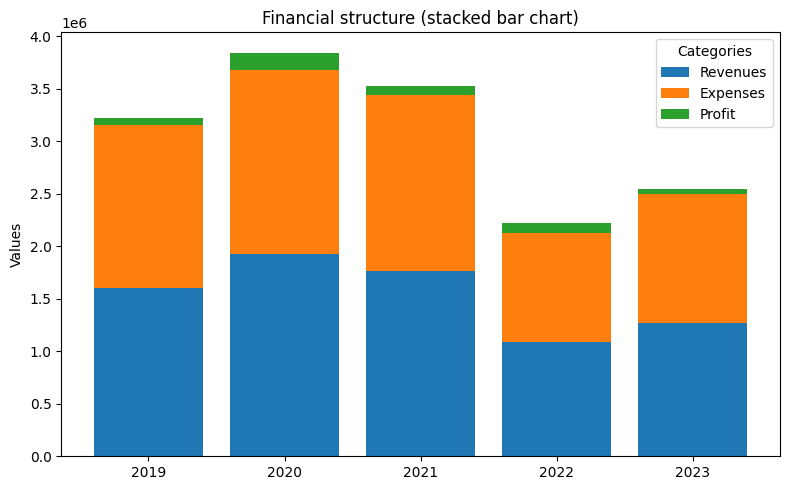

In [ ]:
data = []
for year in years[:]:
    prihodi = fr_components_class_obj.prihod_od_prodaje(year)
    rashodi = fr_components_class_obj._get_aop_value('1013', year)
    dobit = fr_components_class_obj._get_aop_value('1055', year)
    data.append([prihodi, rashodi, dobit])

data = np.array(data)

categories = ["Revenues", "Expenses", "Profit"]
x = np.arange(len(years[:]))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, ax = plt.subplots(figsize=(8, 5))

bottoms = np.zeros(len(x))
for i, category in enumerate(categories):
    ax.bar(x, data[:, i], bottom=bottoms, color=colors[i], label=category)
    bottoms += data[:, i]

# labels
ax.set_xticks(x)
ax.set_xticklabels(years[:5])
ax.set_ylabel("Values")
ax.set_title("Financial structure (stacked bar chart)")
ax.legend(title="Categories")

plt.tight_layout()
plt.show()

Note:

DETAILED ANALYSIS:

From the data overview for 2020, it is evident that operating profit was higher compared to both the previous and subsequent years. This trend suggests that during the COVID-19 pandemic, operational costs were lower or the price differential was higher, which opens the door for a more detailed analysis to determine the causes of this phenomenon.
Additionally, 2022 stands out for a detailed analysis as the profit was higher than in both the previous and subsequent years, despite significantly lower revenues, but also considerably lower expenses. It is worth investigating the factors contributing to the increase in operating margins despite reduced business turnover, which could have a positive effect on cost optimization in future periods.

In [ ]:
# save financial structure results
basic_financial_structure = []

for year in years:
    basic_financial_structure.append(
        {
            "year": year,
            "revenues": fr_components_class_obj.prihod_od_prodaje(year),
            "expenses": fr_components_class_obj._get_aop_value('1013', year),
            "profit": fr_components_class_obj._get_aop_value('1055', year)
        }
    )

if save_results:
    save_result(save_output, "godisnja_finansijska_struktura", basic_financial_structure)

basic_financial_structure_df = pd.DataFrame(basic_financial_structure)

basic_financial_structure_df

,year,revenues,expenses,profit
0,2019,1600822,1550690,71303
1,2020,1928890,1752394,163459
2,2021,1765372,1678526,81723
3,2022,1087184,1038027,98519
4,2023,1270492,1224624,53163


## 2.A. Financial Statements Analysis

2.A.1. Comparative Overview

- The first chart shows a comparison of the performance of the analyzed company over the last 5 years.
- The second chart compares the performance of the last year of the five most important competitors and the analyzed company, with the client's company highlighted in green.
- An additional line chart shows the revenues of the company versus the revenues of its competitors.

Five years of financial results may not be enough to establish a correlation with a high level of reliability. However, by visually inspecting the comparative positions of revenues in relation to other financial items, we can hypothesize a connection between the variables, which provides enough information to formulate a hypothesis for further detailed analysis.

In [ ]:
# Shared variables for comparison visualization
revenue_result = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "1001", years)

company_revenue = revenue_result[0]
competition_revenue = revenue_result[1]

company_revenue

,2019,2020,2021,2022,2023
0,1600822,1928890,1765372,1087184,1270492


Five-year company revenues and competitors' revenues compared to the company's revenue for the last business year.

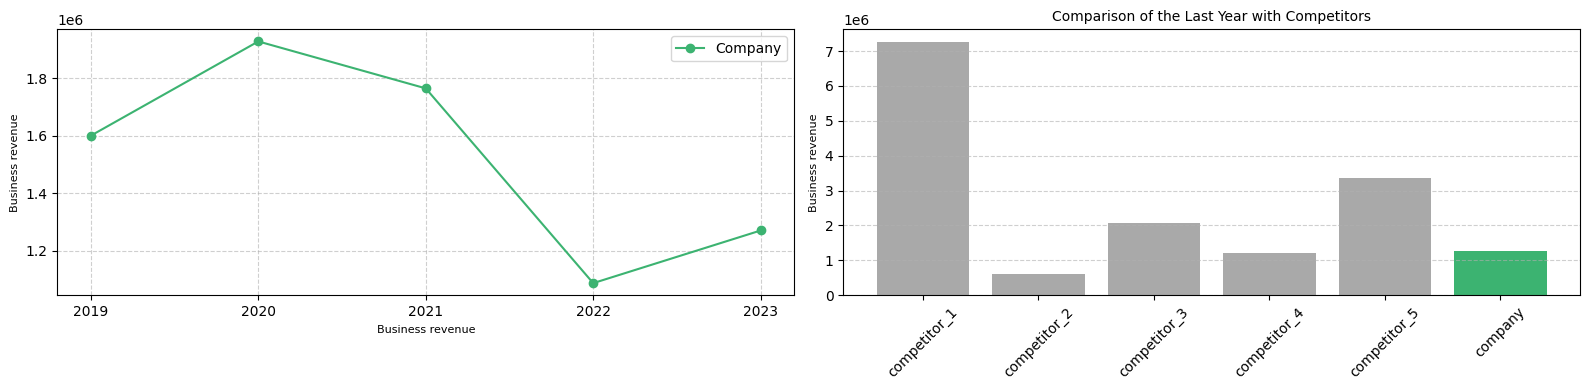

In [ ]:
if save_results:
  save_result(save_output, "5_years_revenue", company_revenue.iloc[0].to_dict())
  save_result(save_output, "competition_revenue", competition_revenue.iloc[0].to_dict())

# Visualization
visualization_class_obj.comparative_analysis_visualization(company_revenue, competition_revenue, 'Business revenue')

### Fixed Assets and Revenue

These comparative results show the efficiency of fixed asset utilization, without the influence of other factors.

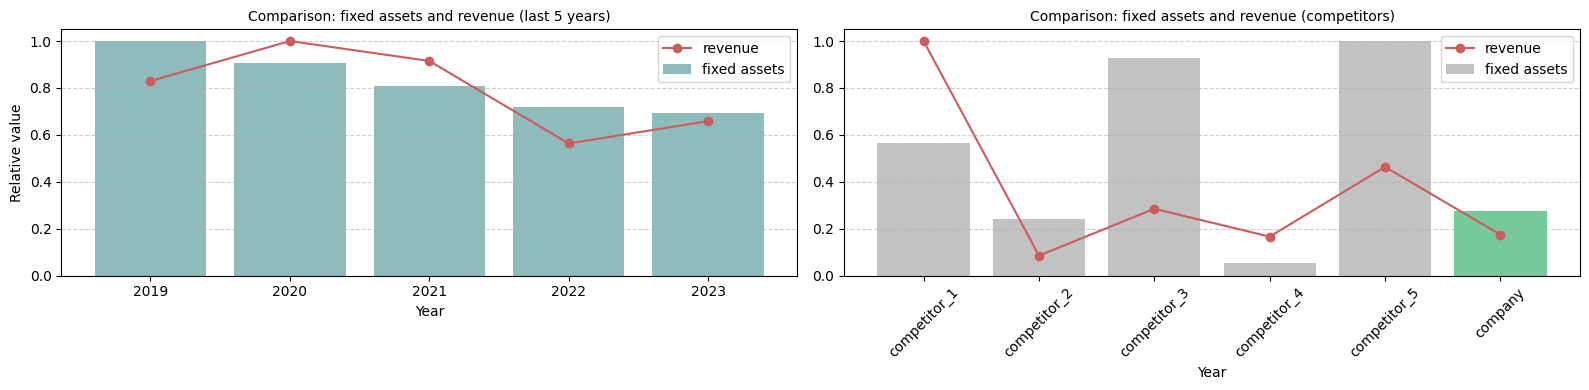

In [ ]:
# Fixed assets / Revenue
result_fixed_assets = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0009", years)

fixed_assets_company = result_fixed_assets[0]
fixed_assets_competition = result_fixed_assets[1]

df_fix_assets_combined_company = pd.concat([fixed_assets_company, company_revenue])
df_fix_assets_combined_competitors = pd.concat([fixed_assets_competition, competition_revenue])
df_swapped = df_fix_assets_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "five_years_fix_assets", [fixed_assets_company.iloc[0].to_dict()])
  save_result(save_output, "competiotion_fixed_assets", [fixed_assets_competition.iloc[0].to_dict()])

# Visualization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_fix_assets_combined_company, df_swapped, "fixed assets")

### Inventory and Revenue

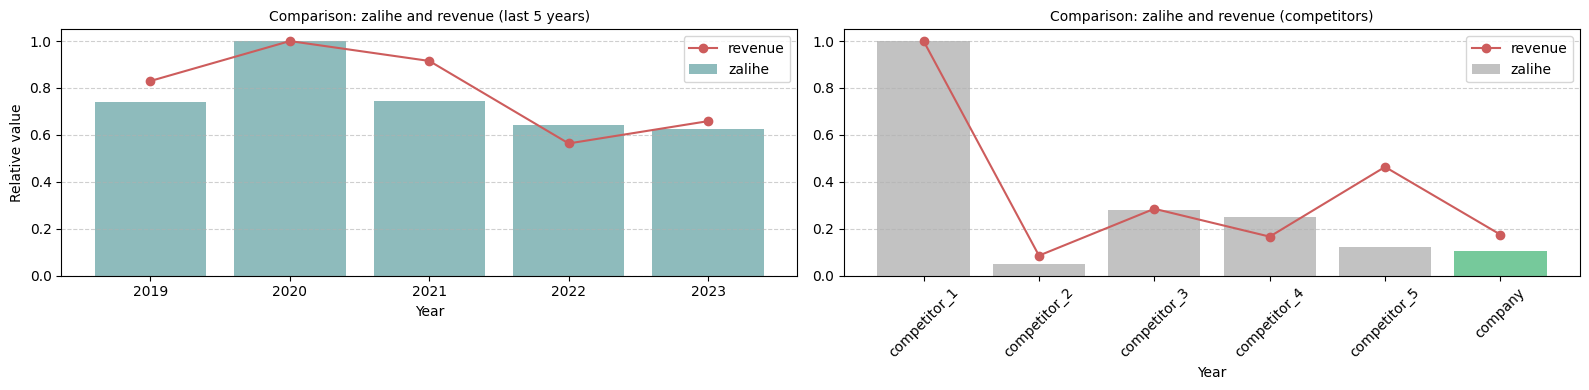

In [ ]:
## Inventory from sales
result_inventory = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0034", years)

inventory_company = result_inventory[0]
inventory_competition = result_inventory[1]

df_inventory_combined_company = pd.concat([inventory_company, company_revenue])
df_inventory_combined_competitors = pd.concat([inventory_competition, competition_revenue])
df_swapped = df_inventory_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "five_years_inventory", [inventory_company.iloc[0].to_dict()])
  save_result(save_output, "competiotion_inventory", [inventory_competition.iloc[0].to_dict()])

# Visualization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_inventory_combined_company, df_swapped, "zalihe")

note:

Based on a rough comparison of inventory levels and revenues, we can assume a parallel movement of inventory and revenue. An unusual value is observed with competitor number 5. Further analysis would involve checking the five-year trend of competitor number 5 (considering the availability of this data in the Business Registers Agency) and analyzing other balance sheet and income statement items to formulate a hypothesis for the cause of this phenomenon.

### Operating Liabilities and Revenue

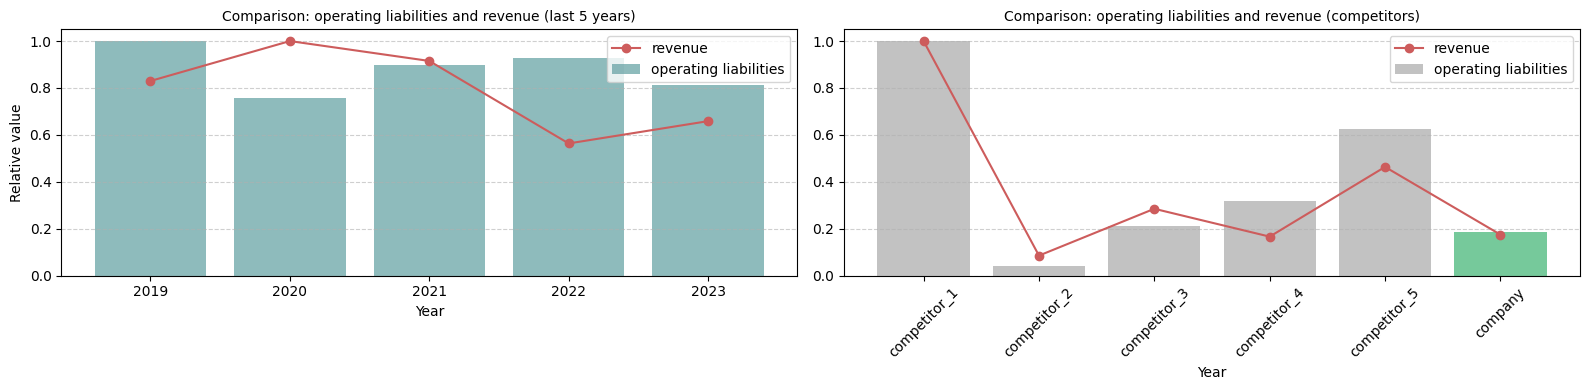

In [ ]:
## Operational_liabilities
result_operational_liabilities = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0442", years)

operational_liabilities_company = result_operational_liabilities[0]
operational_liabilities_competition = result_operational_liabilities[1]

df_operational_liabilities_combined_company = pd.concat([operational_liabilities_company, company_revenue])
df_operational_liabilities_combined_competitors = pd.concat([operational_liabilities_competition, competition_revenue])
df_swapped = df_operational_liabilities_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "five_years_oliablities", [operational_liabilities_company.iloc[0].to_dict()])
  save_result(save_output, "competiotion_", [operational_liabilities_competition.iloc[0].to_dict()])

# Visualization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_operational_liabilities_combined_company, df_swapped, "operating liabilities")

### Loans and Revenue

The source of the hypothesis for further analysis lies in examining the efficiency of loan usage, specifically analyzing the impact of borrowing on revenue generation.

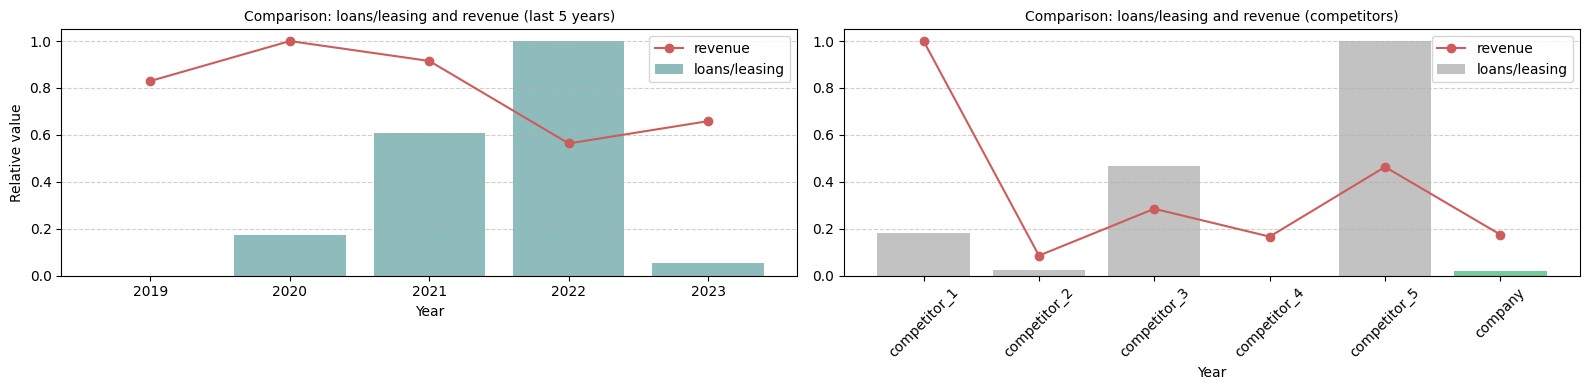

In [ ]:
## Credits from banks & Leasing
result_credits = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0420", years)

credits_company = result_credits[0]
credits_competition = result_credits[1]

df_credits_combined_company = pd.concat([credits_company, company_revenue])
df_credits_combined_competitors = pd.concat([credits_competition, competition_revenue])
df_swapped = df_credits_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "five_years_loans", [credits_company.iloc[0].to_dict()])
  save_result(save_output, "competiotion_loans", [credits_competition.iloc[0].to_dict()])

# Visualization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_credits_combined_company, df_swapped, "loans/leasing")

note:

More precise analysis: The effects of loans, especially long-term ones, may only become evident in the coming years. This would also involve excluding leasing that is not relevant to the business activity, as well as short-term loans for liquidity purposes, from the comparison values.

### Employees and Revenues

The analysis of employees in relation to revenues can provide insights into labor efficiency and its impact on revenue generation. Further analysis could explore how changes in employee count correlate with fluctuations in revenue, helping to identify trends or inefficiencies.


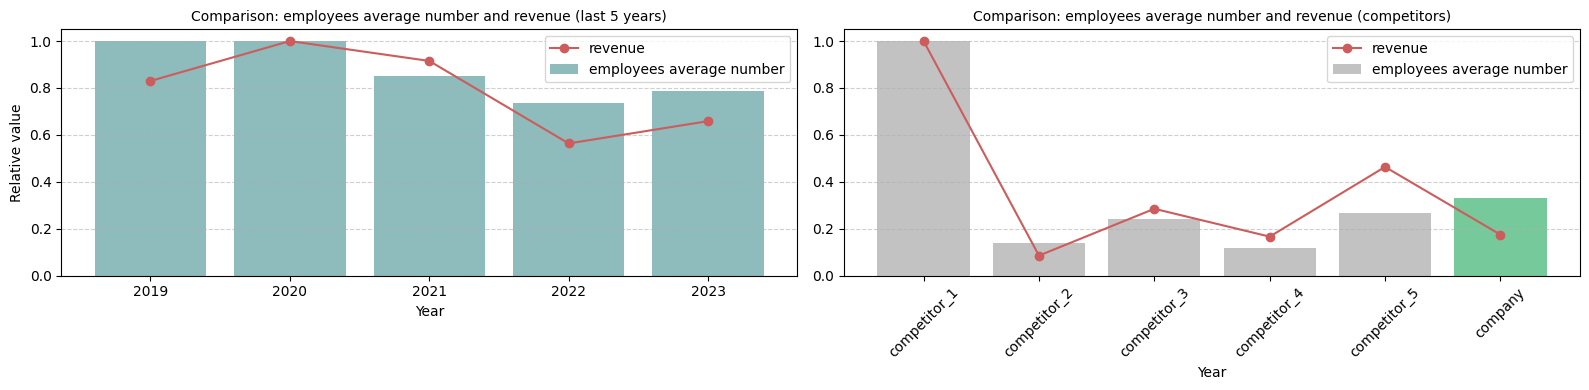

In [ ]:
## Employees
result_employees = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "9005", years)

employees_company = result_employees[0]
employees_competition = result_employees[1]

df_employees_combined_company = pd.concat([employees_company, company_revenue])
df_employees_combined_competitors = pd.concat([employees_competition, competition_revenue])
df_swapped = df_employees_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "five_years_employees", [employees_company.iloc[0].to_dict()])
  save_result(save_output, "competiotion_employees", [employees_competition.iloc[0].to_dict()])

# Visualization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_employees_combined_company, df_swapped, "employees average number")

note:

From the visualization of the number of employees and the company's revenues, as well as the comparative review with competitors, a connection between the number of employees and the level of revenue can be observed. However, a more detailed analysis of employee efficiency would require additional information about the job structure, the role of individual sectors in revenue generation, and productivity per employee. These data would allow for a more accurate assessment of how the number of employees impacts total revenues and how that efficiency can be optimized.

2.A.2. Ratio Analysis

In [ ]:
# Ratio analysis class instance
ratio_analysis_class_obj_company = RatioAnalysis(df_financial_reports, ComponentsFR)
ratio_analysis_class_obj_competition = RatioAnalysis(df_competitors, ComponentsFR)

labels_company = years.copy()
labels_competition = ['competitor_1', 'competitor_2', 'competitor_3', 'competitor_4', 'competitor_5', 'company']

# Create data for visualization
def ratio_results(ratio_name):
    company_ratio_method = getattr(ratio_analysis_class_obj_company, ratio_name)
    competitors_ratio_method = getattr(ratio_analysis_class_obj_competition, ratio_name)

    company_ratio = company_ratio_method()
    competitors_ratio = competitors_ratio_method()

    competitors_ratio.append(company_ratio[-1])

    company_ratio_df = pd.DataFrame([company_ratio], columns=labels_company)
    competitors_ratio_df = pd.DataFrame([competitors_ratio], columns=labels_competition)

    return company_ratio_df, competitors_ratio_df

#### Liquidity

Current Ratio

A financial indicator that measures a company's ability to cover its short-term liabilities using its short-term assets. It is calculated as the ratio of current assets to current liabilities, and ideally, it should be greater than 1, meaning the company has enough assets to settle its debts.

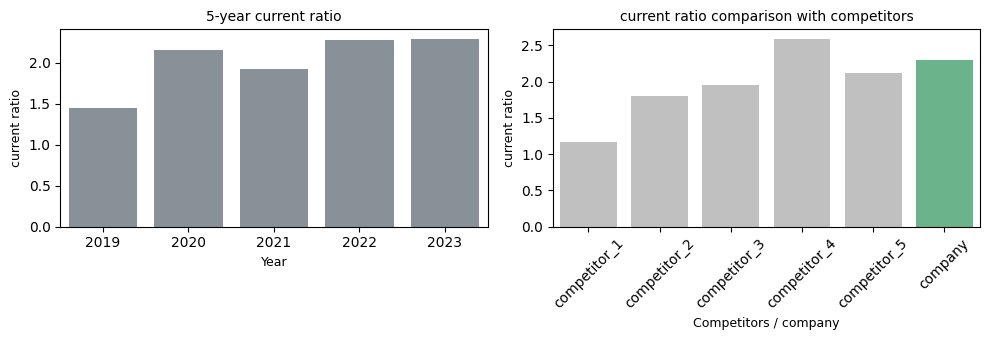

In [ ]:
current_ratio_company_df, current_ratio_competitors_df = ratio_results("current_ratio")

if save_results:
  save_result(save_output, "five_years_currentratio", [current_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_currentratio", [current_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(current_ratio_company_df, current_ratio_competitors_df, 'current ratio', 'g')

Quick Ratio

A liquidity indicator that measures a company's ability to meet its short-term obligations without relying on the sale of inventory. It is calculated as the ratio of current assets (excluding inventory) to current liabilities, with a value greater than 1 indicating a healthy financial position.

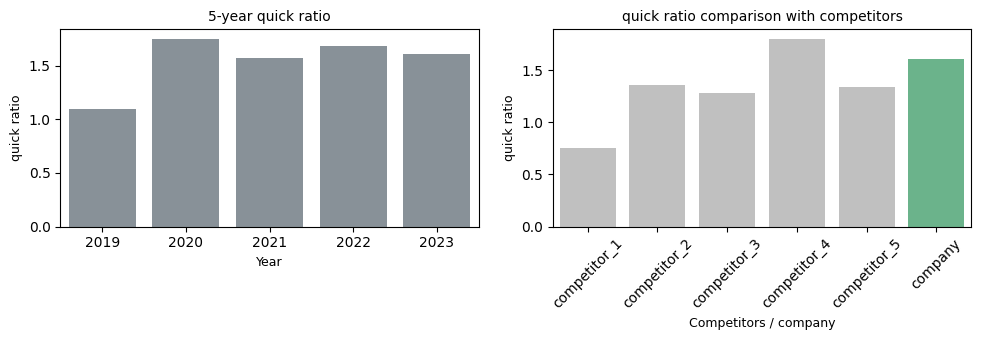

In [ ]:
quick_ratio_company_df, quick_ratio_competitors_df = ratio_results("quick_ratio")

if save_results:
  save_result(save_output, "five_years_quick_ratio", [quick_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_quick_ratio", [quick_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(quick_ratio_company_df, quick_ratio_competitors_df, 'quick ratio', 'g')

#### Solvency

Long-Term Debt Ratio

Measures the proportion of long-term debt in a company's total assets, indicating its reliance on long-term financing. A higher value of this ratio may suggest greater financial leverage and potential risk, while a lower value indicates less dependence on debt to finance growth.

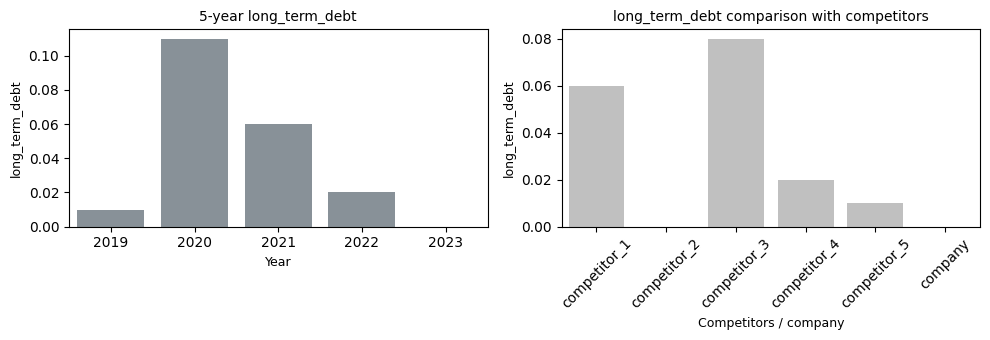

In [ ]:
lt_debt_ratio_company_df, lt_debt_ratio_competitors_df = ratio_results("long_term_debt_ratio")

if save_results:
  save_result(save_output, "five_years_long_term_debt", [lt_debt_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_long_term_debt", [lt_debt_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(lt_debt_ratio_company_df, lt_debt_ratio_competitors_df, 'long_term_debt', 'g')

Debt to Equity Ratio

Shows the relationship between a company's debt and its shareholders' equity. This ratio measures the level of a company's indebtedness relative to the owners' investments, where a higher value may indicate greater financial leverage and potential risk for investors.

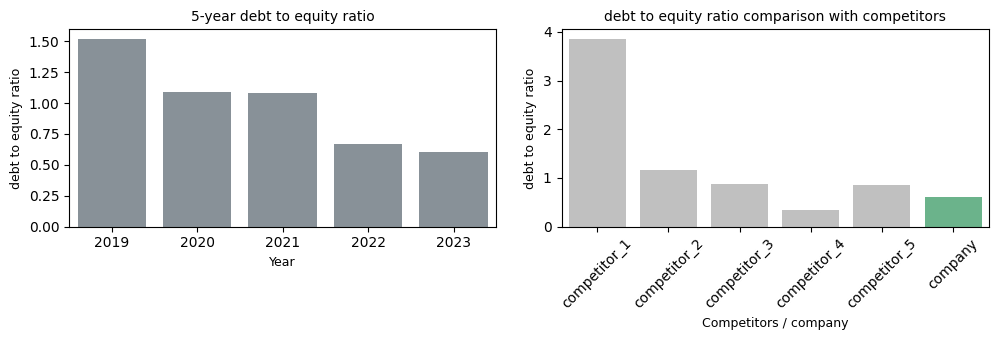

In [ ]:
debt_to_equity_ratio_company_df, debt_to_equity_ratio_competitors_df = ratio_results("debt_to_equity")

if save_results:
  save_result(save_output, "five_years_debt_to_equity", [debt_to_equity_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_debt_to_equity", [debt_to_equity_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(debt_to_equity_ratio_company_df, debt_to_equity_ratio_competitors_df, 'debt to equity ratio', 'g')

#### Profitability

Gross Profit Margin Ratio

Indicates how much a company retains as gross profit from each unit of revenue after covering production or procurement costs. This metric reflects the company's efficiency in controlling its production or procurement expenses relative to its total revenue.

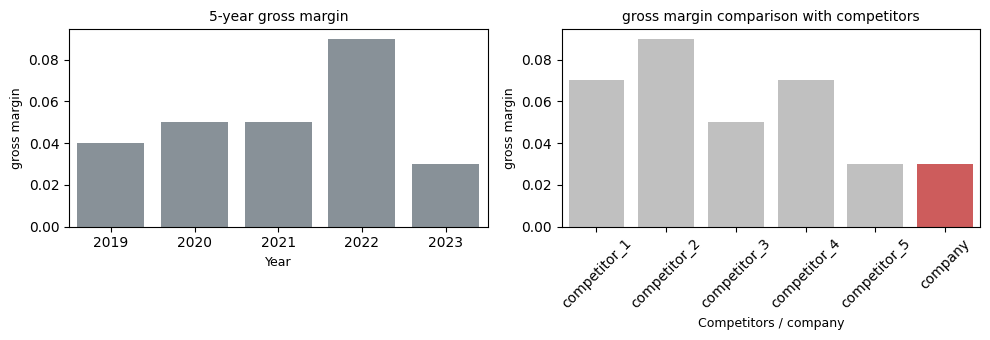

In [ ]:
gp_margin_ratio_company_df, gp_margin_ratio_competitors_df = ratio_results("gross_profit_margin")

if save_results:
  save_result(save_output, "five_years_gross_margin", [gp_margin_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_gross_margin", [gp_margin_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(gp_margin_ratio_company_df, gp_margin_ratio_competitors_df, 'gross margin', 'r')

Net Profit Margin Ratio

Measures the percentage of revenue a company retains as net profit after deducting all expenses, taxes, and other costs. This metric indicates the overall profitability of the company and its ability to generate profit from each unit of revenue.

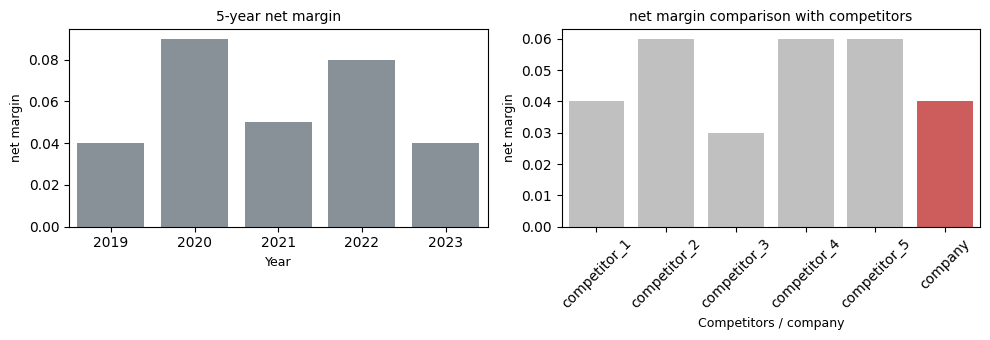

In [ ]:
np_margin_ratio_company_df, np_margin_ratio_competitors_df = ratio_results("net_profit_margin")

if save_results:
  save_result(save_output, "five_years_net_margin", [np_margin_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_net_margin", [np_margin_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(np_margin_ratio_company_df, np_margin_ratio_competitors_df, 'net margin', 'r')

Return on Business Assets (ROBA) Ratio

Measures how much profit a company generates relative to its core business assets, excluding non-essential assets such as cash and short-term receivables. This metric helps assess the efficiency of utilizing resources specific to business operations in generating profit.

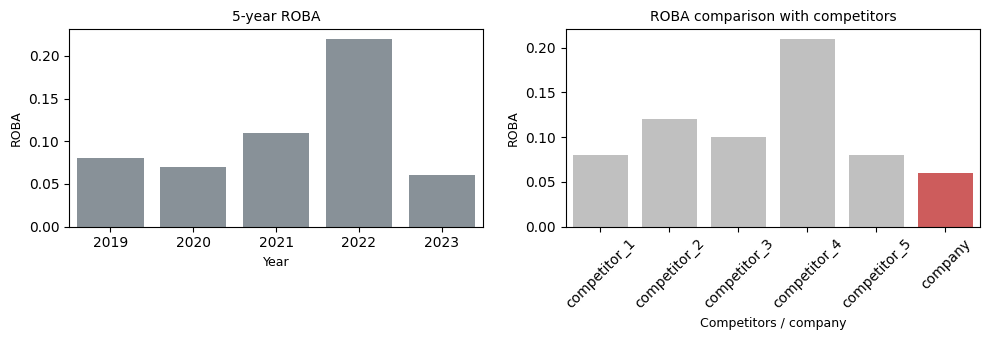

In [ ]:
roa_ratio_company_df, roa_ratio_competitors_df = ratio_results("return_on_bussines_assets")

if save_results:
  save_result(save_output, "five_years_ROBA", [roa_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_ROBA", [roa_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(roa_ratio_company_df, roa_ratio_competitors_df, 'ROBA', 'r')

Return on Equity (ROE) Ratio

A metric that measures a company's profitability relative to the equity invested by its shareholders. ROE indicates how much the company earns for each unit of shareholder investment, making it a useful indicator for assessing the efficiency of utilizing equity capital.

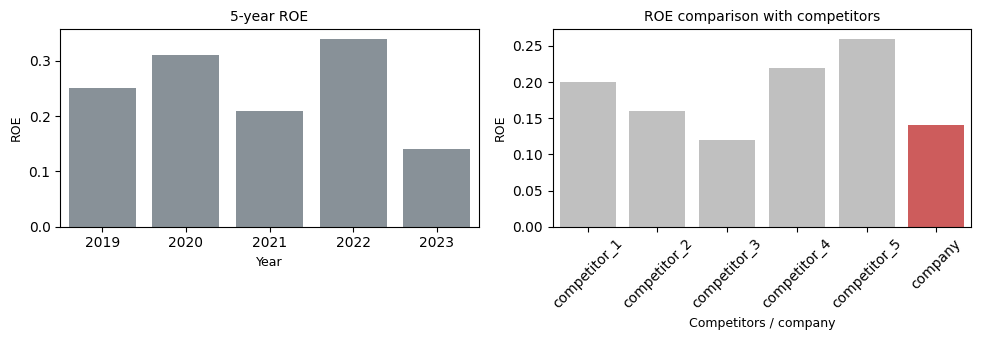

In [ ]:
roe_ratio_company_df, roe_ratio_competitors_df = ratio_results("return_on_equity")

if save_results:
  save_result(save_output, "five_years_ROE", [roe_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "competiotion_ROE", [roe_ratio_competitors_df.iloc[0].to_dict()])

# Visualization
visualization_class_obj.barplot_ratio_analysis(roe_ratio_company_df, roe_ratio_competitors_df, 'ROE', 'r')

## 2.B. Analysis of the General Ledger Journal

#### Revenue and Expense Structure

In [ ]:
# Revenue
df_revenue_2023 = df[(df['date'].dt.year == 2023) & (df['account'].str.startswith('6'))]
revenue_structure = (df_revenue_2023.groupby(df_revenue_2023['account'].str[:2])['credit']
          .sum()
          .loc[lambda x: x >= 1]
          .to_dict())
sum_revenue = sum(revenue_structure.values())

revenue_structure_result = {key: round(value/sum_revenue, 2) for key, value in revenue_structure.items()}
df_revenue_structure = pd.DataFrame(revenue_structure_result.items(), columns=['account_group', 'value'])
revenue_structure_result

# Expenses
df_expenses_2023 = df[(df['date'].dt.year == 2023) & (df['account'].str.startswith('5'))]
expenses_structure = (df_expenses_2023.groupby(df_expenses_2023['account'].str[:2])['debit']
          .sum()
          .loc[lambda x: x >= 1]
          .to_dict())
sum_expenses = sum(expenses_structure.values())

expenses_structure_result = {key: round(value/sum_expenses, 2) for key, value in expenses_structure.items()}
df_expenses_structure = pd.DataFrame(expenses_structure_result.items(), columns=['account_group', 'value'])

if save_results:
  save_result(save_output, "revenue_structure", [revenue_structure_result])
  save_result(save_output, "expenses_structure", [expenses_structure_result])
df_revenue_structure

,account_group,value
0,60,0.95
1,61,0.03
2,62,0.00
3,65,0.00
4,66,0.00
5,67,0.01
6,68,0.01


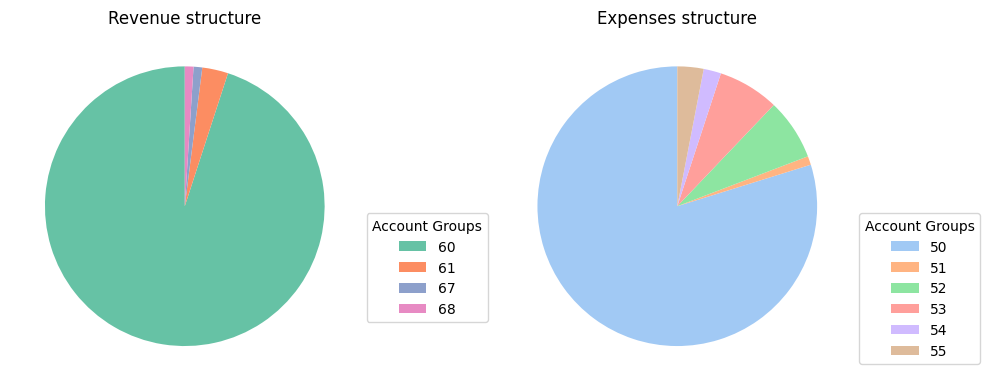

In [ ]:
account_group_revenue = df_revenue_structure['account_group']
values_revenue = df_revenue_structure['value']

account_group_expenses = df_expenses_structure['account_group']
values_expense = df_expenses_structure['value']

filtered_groups_revenue = [str(group) for group, value in zip(account_group_revenue, values_revenue) if value > 0]
filtered_values_revenue = [value for value in values_revenue if value > 0]

filtered_groups_expense = [str(group) for group, value in zip(account_group_expenses, values_expense) if value > 0]
filtered_values_expense = [value for value in values_expense if value > 0]

# Visualization
colors_revenue = sb.color_palette("Set2", len(filtered_values_revenue))
colors_expense = sb.color_palette("pastel", len(filtered_values_expense))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(filtered_values_revenue, labels=None, autopct=None, startangle=90, colors=colors_revenue)
ax1.set_title("Revenue structure")

ax2.pie(filtered_values_expense, labels=None, autopct=None, startangle=90, colors=colors_expense)
ax2.set_title("Expenses structure")

ax1.legend(filtered_groups_revenue, title="Account Groups", loc="upper left", bbox_to_anchor=(1, 0.5))
ax2.legend(filtered_groups_expense, title="Account Groups", loc="upper left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


#### Inventory Inflows and Outflows

In [ ]:
df_inventory = df[(df['date'].dt.year == 2023) &
                 (df['account'].str.startswith('13'))].copy()

df_inventory['week'] = df_inventory['date'].dt.isocalendar().week

result = df_inventory.groupby('week').agg({'debit': 'sum', 'credit': 'sum'}).reset_index()

inv_in_out = result.loc[:, ['debit', 'credit']] = round(result[['debit', 'credit']] / 1000)

# Prepare save results
json_result = [
        {"week": row['week'], "debit": row['debit'], "credit": row['credit']}
        for _, row in result.iterrows()
    ]

if save_results:
    save_result(save_output, "52-Week Inventory Inflows and Outflows", json_result)

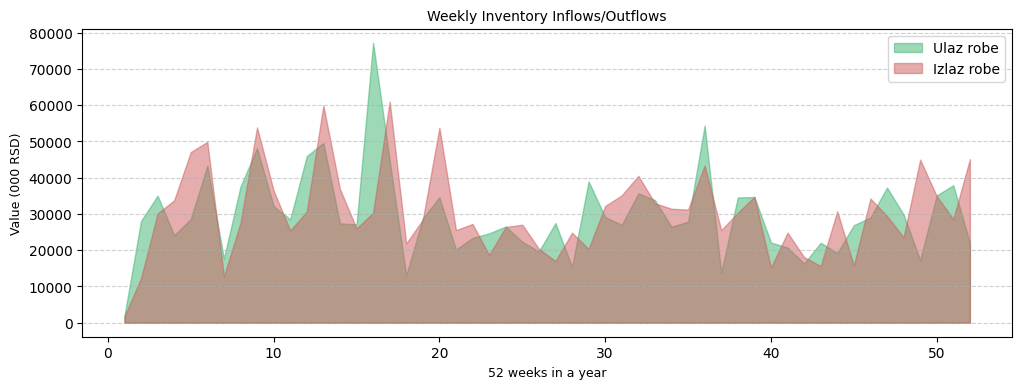

In [ ]:
# Visualization
plt.figure(figsize=(12, 4))

plt.fill_between(result['week'], result['debit'], label='Ulaz robe', color='MediumSeaGreen', alpha=0.5)
plt.fill_between(result['week'], result['credit'], label='Izlaz robe', color='IndianRed', alpha=0.5)

plt.title('Weekly Inventory Inflows/Outflows', fontsize=10)
plt.xlabel('52 weeks in a year', fontsize=9)
plt.ylabel('Value (000 RSD)', fontsize=9)

plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Note:

A more detailed analysis of procurement efficiency and inventory management optimization can be performed with additional data from auxiliary inventory records.

#### Weekly Cash Position

We observe the cash position on a weekly basis, without cumulative representation and the opening balance, in order to determine if there is excessive retention of unused cash.

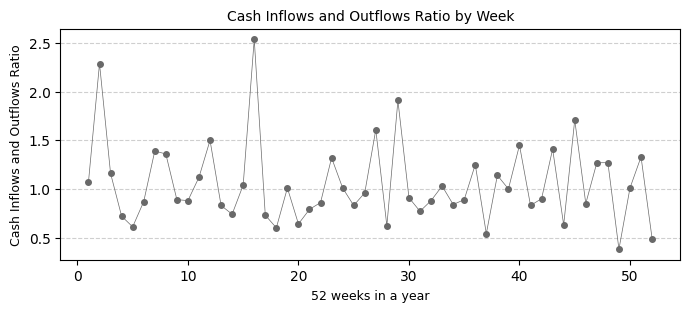

In [ ]:
df_cash = df[(df['date'].dt.year == 2023) &
                 (df['account'].str.startswith('24'))].copy()

df_cash['week'] = df_cash['date'].dt.isocalendar().week

cash_result = df_cash.groupby('week').agg({'debit': 'sum', 'credit': 'sum'}).reset_index()

cash_result.loc[:, ['debit', 'credit']] = result[['debit', 'credit']] / 1000
cash_result['debit_to_credit'] = result['debit'] / result['credit']

cash_result = cash_result[['week', 'debit_to_credit']].assign(debit_to_credit=cash_result['debit_to_credit'].round(2))

# Prepare save results
json_result = [
        {"week": row['week'], "debit_to_credit": row['debit_to_credit']}
        for _, row in cash_result.iterrows()
    ]

if save_results:
    save_result(save_output, "52-nedeljni_neto_inventar", json_result)

# Visuelization
plt.figure(figsize=(8, 3))

plt.plot(cash_result['week'], cash_result['debit_to_credit'], marker='o', linestyle='-', linewidth=0.5, color='DimGray', markersize=4)

plt.title('Cash Inflows and Outflows Ratio by Week', fontsize=10)
plt.xlabel('52 weeks in a year', fontsize=9)
plt.ylabel('Cash Inflows and Outflows Ratio', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

note:

Although the net cash value in week 10 increased by about three times, it can be concluded that this cash was already utilized in the following period.

A more detailed analysis would focus on determining the factors influencing the efficient use of cash in business operations.

### Customers

In [ ]:
customers_df = df.copy()

customers_df['month'] = customers_df['date'].dt.month

customers_df['week'] = ((customers_df['date'].dt.dayofyear - 1) // 7 + 1) % 52
customers_df['week'] = customers_df['week'].replace(0, 52)

account_condition = (
    (customers_df['account'].str.startswith('200') & ~customers_df['account'].str.startswith('2009')) |
    (customers_df['account'].str.startswith('201') & ~customers_df['account'].str.startswith('2019')) |
    (customers_df['account'].str.startswith('204') & ~customers_df['account'].str.startswith('2049')) |
    (customers_df['account'].str.startswith('205') & ~customers_df['account'].str.startswith('2059'))
)

mask = (
    account_condition &
    (customers_df['debit'] > 0)
)

customers_df = customers_df[mask]
customers_df = customers_df.drop(columns=['credit'])
customers_df_2023 = customers_df[customers_df['date'].dt.year == 2023].copy()

# Prepare save results
monthly_sum = customers_df_2023.groupby('month')['debit'].sum() / 1000
monthly_sum = monthly_sum.reset_index()

monthly_sum['debit'] = monthly_sum['debit'].round()

months = monthly_sum['month'].to_list()
debit_sums = monthly_sum['debit'].to_list()

json_result = [{"month": key, "customers_sum": value} for key, value in zip(months, debit_sums)]

if save_results:
    save_result(save_output, "12-months_customers_value", json_result)

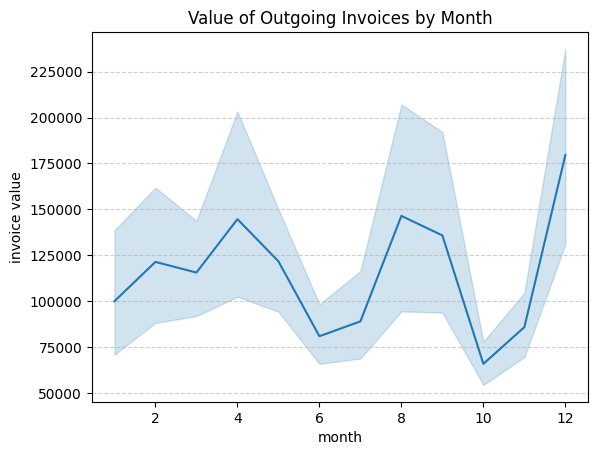

In [ ]:
# Visuelization
ax = sb.lineplot(data=customers_df_2023, x='month', y='debit')

ax.set(xlabel='month')
ax.set(ylabel='invoice value')
ax.set(title='Value of Outgoing Invoices by Month')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

note:

The chart showing the value of outgoing invoices by month indicates that April (4), August (8), and December (12) are specific months due to the higher and more variable invoice values compared to other months. This phenomenon is visually highlighted by a wider range (shadow) around the trend line for these months.

Further interpretation and analysis could involve investigating seasonal factors, changes in customer structure, comparisons with previous years, and other relevant aspects. The goal of these investigations would be to identify the causes of these deviations, and if they are systemic in nature, to leverage them to increase revenue in future periods.

#### Domestic Customers vs. Foreign Customers

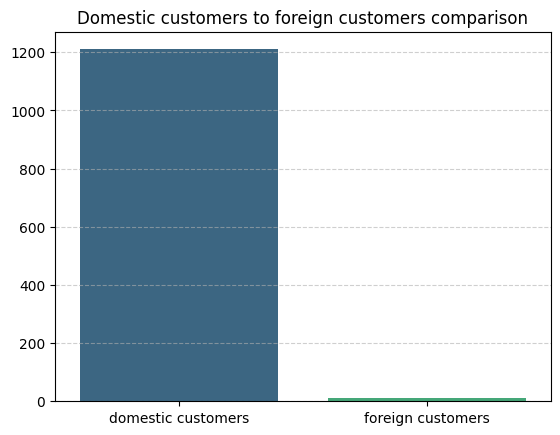

In [ ]:
d_mask = (
    (customers_df['account'].str.startswith('200')) | (customers_df['account'].str.startswith('204'))
)

f_mask = (
    (customers_df['account'].str.startswith('201')) | (customers_df['account'].str.startswith('205'))
)

customers_df['week'].unique()
d_customers_df = customers_df[d_mask]
f_customers_df = customers_df[f_mask]

# Prepare save results
data = [d_customers_df['account'].nunique(), f_customers_df['account'].nunique()]
labels = ['domestic customers', 'foreign customers']

json_result = [
    {
        'domestic customers': d_customers_df['account'].nunique(),
        'foreign customers': f_customers_df['account'].nunique()
    }
]

if save_results:
    save_result(save_output, "domaci_prema_stranim_kupcima", json_result)

# Visuelization
sb.barplot(x=labels, y=data, hue=labels, palette='viridis')
plt.title("Domestic customers to foreign customers comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
d_weekly_sum = d_customers_df.groupby('week')['debit'].sum().reset_index()
f_weekly_sum = f_customers_df.groupby('week')['debit'].sum().reset_index()

f_customers_df

weeks = list(range(1, 53))
d_values = d_weekly_sum['debit'].to_list()
f_values = f_weekly_sum['debit'].to_list()

# fix for values because sometimes there are less then 52 summed values (no values in that period)
d_values = d_values + [0] * (52 - len(d_values)) if len(d_values) < 52 else d_values[:52]
f_values = f_values + [0] * (52 - len(f_values)) if len(f_values) < 52 else f_values[:52]

json_result = [{"week": week, "domestic_customers": d_value, "foreign_customer": f_value} for week, d_value, f_value in zip(weeks, d_values, f_values)]

if save_results:
    save_result(save_output, "52-week_domestic_foreign_customers", json_result)

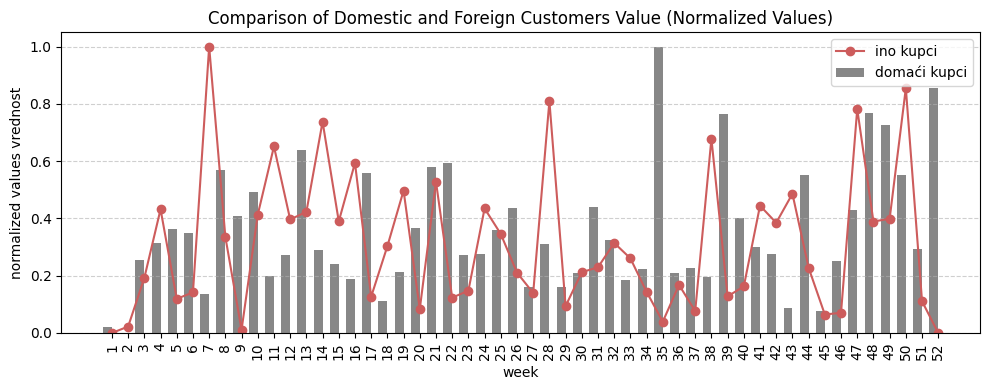

In [ ]:
# Values normalization
d_values_normalized = (d_weekly_sum['debit'] - d_weekly_sum['debit'].min()) / (d_weekly_sum['debit'].max() - d_weekly_sum['debit'].min())
f_values_normalized = (f_weekly_sum['debit'] - f_weekly_sum['debit'].min()) / (f_weekly_sum['debit'].max() - f_weekly_sum['debit'].min())

d_values_normalized = d_values_normalized.tolist() + [0] * (52 - len(d_values_normalized))
f_values_normalized = f_values_normalized.tolist() + [0] * (52 - len(f_values_normalized))

# Vizualization
bar_width = 0.55
weeks = np.arange(1, 53)

plt.figure(figsize=(10, 4))

plt.bar(weeks - bar_width / 2, d_values_normalized, width=bar_width, label='domaći kupci', color='DimGray', alpha=0.8)
plt.plot(weeks, f_values_normalized, label='ino kupci', color='IndianRed', marker='o', linewidth=1.5)

plt.xlabel('week')
plt.ylabel('normalized values vrednost')
plt.title('Comparison of Domestic and Foreign Customers Value (Normalized Values)')
plt.xticks(weeks, rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


note:

The values shown in this parallel chart are normalized values and do not represent the actual values of domestic and foreign customers. The goal of the visual presentation is to compare the fluctuations in the values of domestic and foreign customers on a weekly basis throughout the year, allowing us to identify potential patterns of correlation, such as joint increases or decreases in the values of domestic and foreign customers during specific periods of the year.

#### Old Customers vs. New Customers

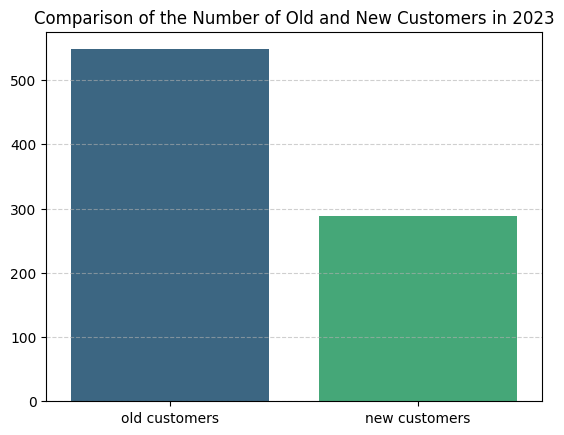

In [ ]:
date_filter = customers_df['date'].dt.year == 2022
account_filter = customers_df['account'].str.startswith('2') & customers_df['account'].str.contains('-')

old_customers_lst = customers_df[date_filter & account_filter]['account'].to_list()

old_customers = customers_df_2023[customers_df_2023['account'].isin(old_customers_lst)]
new_customers = customers_df_2023[~customers_df_2023['account'].isin(old_customers_lst)]

data = [old_customers['account'].nunique(), new_customers['account'].nunique()]

save_data = [{
    "broj_starih_kupaca": data[0],
    "broj_novih_kupaca": data[1]
}]

if save_results:
    save_result(save_output, "broj_starih_novih_kupaca", save_data)

# Visualization
labels = ['old customers', 'new customers']
sb.barplot(x=labels, y=data, hue=labels, palette='viridis')
plt.title("Comparison of the Number of Old and New Customers in 2023")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Value of Old vs. New Customers (Comparative Review)

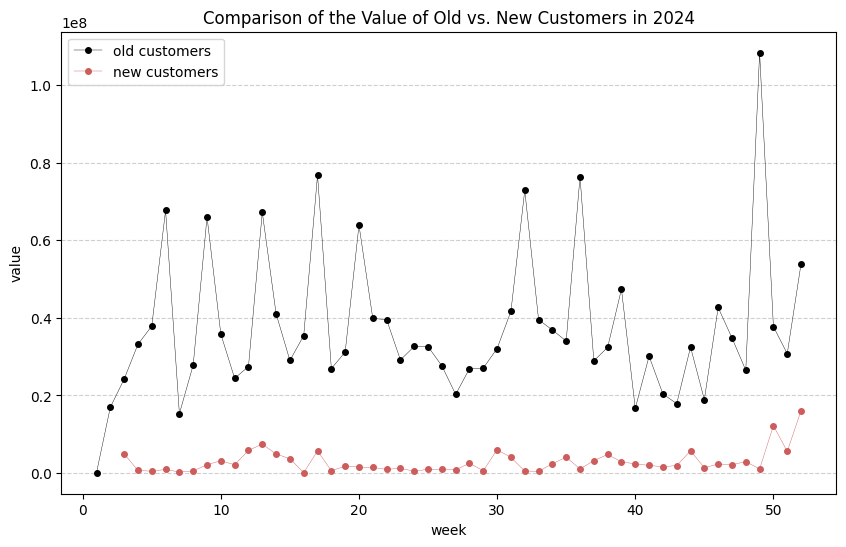

In [ ]:
old_weekly_sum = old_customers.groupby('week')['debit'].sum().reset_index()
new_weekly_sum = new_customers.groupby('week')['debit'].sum().reset_index()

# Data preparation for saving
weeks = list(range(1, 53))
old_customers_values = old_weekly_sum['debit'].to_list()
new_customer_values = new_weekly_sum['debit'].to_list()

# fix for values there are less then 52 summed values (no values in that period)
old_c_values = old_customers_values + [0] * (52 - len(old_customers_values)) if len(old_customers_values) < 52 else old_customers_values[:52]
new_c_values = new_customer_values + [0] * (52 - len(new_customer_values)) if len(new_customer_values) < 52 else new_customer_values[:52]

json_result = [{"week": week, "old_customers": o_value, "new_customers": n_value} for week, o_value, n_value in zip(weeks, old_c_values, new_c_values)]

if save_results:
    save_result(save_output, "vrednost_star_novi_kupci", json_result)

# Visualization
plt.figure(figsize=(10, 6))

plt.plot(old_weekly_sum['week'], old_weekly_sum['debit'], lw = 0.3, label='old customers', color='Black', marker='o', markersize=4)

plt.plot(new_weekly_sum['week'], new_weekly_sum['debit'], lw = 0.3, label='new customers', color='IndianRed', marker='o', markersize=4)

plt.xlabel('week')
plt.ylabel('value')
plt.title('Comparison of the Value of Old vs. New Customers in 2024')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

note:

Without delving into a detailed analysis of customers, based on the insights into the number and value of old vs. new customers, it can be concluded that the number and value of customers with long-standing relationships are significantly higher. These customers, although they may not contribute significantly to market expansion, form the foundation for generating the majority of the company's revenue. Therefore, these customers should be prioritized in further analysis to maintain existing relationships, as they represent long-term stability and a reliable source of income. Additionally, there is a noticeable increase in the value of both old and new customers during the final weeks of the year. This pattern needs to be confirmed by checking previous years to reliably optimize inventory levels for the end of the year.

#### Frequency of Purchases and Transaction Value

Given that we have identified the customers to focus on, the next step in the analysis would be to determine whether these customers have a greater impact through their average purchase frequency or the value of individual invoices.

In [ ]:
# old customers
mask = ((old_customers['account'].str.startswith('200')) | (old_customers['account'].str.startswith('204')))

old_domestic_customers_df = old_customers[mask]

account_stats = old_domestic_customers_df.groupby(['account', 'month', 'week']).agg(
    frequency=('account', 'count'),
    avg_value=('debit', 'mean')
).reset_index()

monthly_stats = account_stats.groupby('month').agg(
    total_frequency=('frequency', 'sum'),
    avg_value_per_month=('avg_value', 'mean')
).reset_index().assign(
    avg_value_per_month=lambda x: x['avg_value_per_month'].round(2)
)

monthly_stats

# Prepare save results
months = list(range(1, 13))
customers_frequency = monthly_stats['total_frequency'].to_list()
customer_avg_value = monthly_stats['avg_value_per_month'].to_list()

json_result = [{"month": month, "monthly_customers_invoice_requency": freq, "monthly_customers_avg_value": avg_val} for month, freq, avg_val in zip(months, customers_frequency, customer_avg_value)]

if save_results:
    save_result(save_output, "monthly_purchase_frequency_average_value", json_result)

The results of purchase frequency and average invoice values will be visually presented by month, but there is no correlation between them.

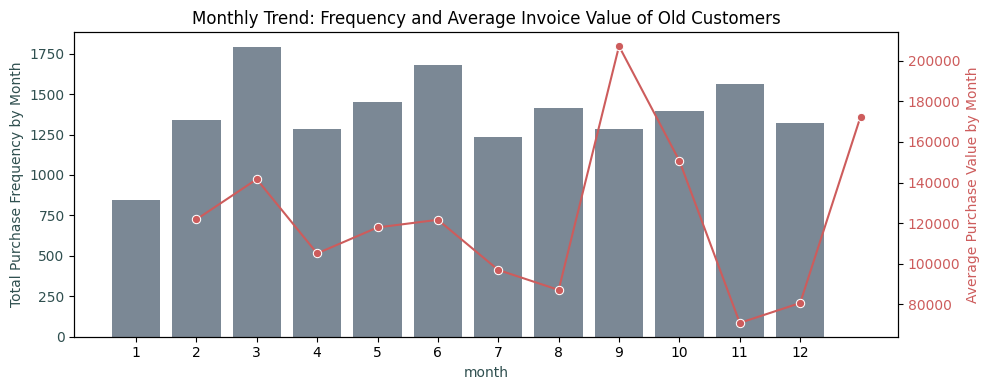

In [ ]:
monthly_stats = account_stats.groupby('month').agg(
    total_frequency=('frequency', 'sum'),
    avg_value_per_month=('avg_value', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 4))

sb.barplot(x='month', y='total_frequency', data=monthly_stats, color='LightSlateGrey', ax=ax1)
ax1.set_ylabel('Total Purchase Frequency by Month', color='DarkSlateGray')
ax1.tick_params(axis='y', labelcolor='DarkSlateGray')

ax2 = ax1.twinx()
sb.lineplot(x='month', y='avg_value_per_month', data=monthly_stats, color='IndianRed', marker='o', ax=ax2)
ax2.set_ylabel('Average Purchase Value by Month', color='IndianRed')
ax2.tick_params(axis='y', labelcolor='IndianRed')

ax1.set_xlabel('month', color='DarkSlateGray')
plt.title('Monthly Trend: Frequency and Average Invoice Value of Old Customers')
plt.tight_layout()
plt.show()


In [ ]:
correlation = account_stats[['avg_value', 'frequency']].corr()

correlation

,avg_value,frequency
avg_value,1.00000,-0.00866
frequency,-0.00866,1.00000


The correlation between purchase frequency and average invoice value is very negative and low (-0.00866), indicating a lack of significant linear relationship. A higher purchase frequency does not necessarily imply higher average invoice values, and vice versa.

note:

Further analysis of customers can be focused on comparing payment days for four customer groups (domestic-foreign-old-new), as well as identifying factors we can influence that would have a significant impact on retaining existing customers and acquiring new ones.

### Further Analysis

**Further analysis can cover a wide range of areas, depending on the depth and objectives. The focus can be directed towards key metrics that will provide insights for business decision-making, considering the specific needs of the company.**